In [1]:
!pip install xgboost
!pip install scikit-learn
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 25.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 25.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import shap
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load Data
file_path = "crime dataset.csv"

# These features were chosen based on feature selection testes (in appendix)
columns_to_use = [
    "LAW_CAT_CD", # Target Variable
    "SUSP_RACE",
    "SUSP_AGE_GROUP",
    "SUSP_SEX",
    "VIC_SEX",
    "CRM_ATPT_CPTD_CD",
    "VIC_AGE_GROUP",
    "VIC_RACE",
    "LOC_OF_OCCUR_DESC",
    "PREM_TYP_DESC",
    "ADDR_PCT_CD",
    "JURISDICTION_CODE",
    "STATION_NAME",
    "BORO_NM",
    "PARKS_NM",
    "HADEVELOPT"]

df = pd.read_csv(file_path, usecols = columns_to_use)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9491946 entries, 0 to 9491945
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ADDR_PCT_CD        float64
 1   CRM_ATPT_CPTD_CD   object 
 2   LAW_CAT_CD         object 
 3   BORO_NM            object 
 4   LOC_OF_OCCUR_DESC  object 
 5   PREM_TYP_DESC      object 
 6   JURISDICTION_CODE  int64  
 7   PARKS_NM           object 
 8   HADEVELOPT         object 
 9   SUSP_AGE_GROUP     object 
 10  SUSP_RACE          object 
 11  SUSP_SEX           object 
 12  STATION_NAME       object 
 13  VIC_AGE_GROUP      object 
 14  VIC_RACE           object 
 15  VIC_SEX            object 
dtypes: float64(1), int64(1), object(14)
memory usage: 1.1+ GB


In [4]:
# 2. Preprocessing

# Drop rows with missing target
df = df.dropna(subset=["LAW_CAT_CD"])

# Fill NaNs in features
df.fillna("UNKNOWN", inplace=True)

# Force all object columns to string to avoid mixed types
label_encoders = {}
for col in df.columns:
    if df[col].dtype == "object" or df[col].dtype.name == 'category':
        df[col] = df[col].astype(str)  # 👈 FORCE to string

        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

df.info()

# Features and Target
X = df.drop("LAW_CAT_CD", axis=1)
y = df["LAW_CAT_CD"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9491946 entries, 0 to 9491945
Data columns (total 16 columns):
 #   Column             Dtype
---  ------             -----
 0   ADDR_PCT_CD        int64
 1   CRM_ATPT_CPTD_CD   int64
 2   LAW_CAT_CD         int64
 3   BORO_NM            int64
 4   LOC_OF_OCCUR_DESC  int64
 5   PREM_TYP_DESC      int64
 6   JURISDICTION_CODE  int64
 7   PARKS_NM           int64
 8   HADEVELOPT         int64
 9   SUSP_AGE_GROUP     int64
 10  SUSP_RACE          int64
 11  SUSP_SEX           int64
 12  STATION_NAME       int64
 13  VIC_AGE_GROUP      int64
 14  VIC_RACE           int64
 15  VIC_SEX            int64
dtypes: int64(16)
memory usage: 1.1 GB


In [5]:
# 3. Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(label_encoders['LAW_CAT_CD'].classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    tree_method="hist"  # Faster on CPU for large datasets
)

print("Training XGBoost model...")

# Add eval_set to monitor progress
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_clf.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True
)

Training XGBoost model...
[0]	validation_0-mlogloss:1.06876	validation_1-mlogloss:1.06875
[1]	validation_0-mlogloss:1.04319	validation_1-mlogloss:1.04316
[2]	validation_0-mlogloss:1.02119	validation_1-mlogloss:1.02115
[3]	validation_0-mlogloss:1.00208	validation_1-mlogloss:1.00202
[4]	validation_0-mlogloss:0.98502	validation_1-mlogloss:0.98495
[5]	validation_0-mlogloss:0.97012	validation_1-mlogloss:0.97003
[6]	validation_0-mlogloss:0.95707	validation_1-mlogloss:0.95696
[7]	validation_0-mlogloss:0.94549	validation_1-mlogloss:0.94537
[8]	validation_0-mlogloss:0.93502	validation_1-mlogloss:0.93489
[9]	validation_0-mlogloss:0.92588	validation_1-mlogloss:0.92573
[10]	validation_0-mlogloss:0.91762	validation_1-mlogloss:0.91746
[11]	validation_0-mlogloss:0.91000	validation_1-mlogloss:0.90982
[12]	validation_0-mlogloss:0.90302	validation_1-mlogloss:0.90284
[13]	validation_0-mlogloss:0.89694	validation_1-mlogloss:0.89674
[14]	validation_0-mlogloss:0.89133	validation_1-mlogloss:0.89112
[15]	vali

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [6]:
# 4. Evaluate the model
print("Evaluating model...")
y_pred = xgb_clf.predict(X_test)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoders['LAW_CAT_CD'].classes_))

Evaluating model...
Accuracy: 0.5917

Classification Report:
              precision    recall  f1-score   support

      FELONY       0.59      0.26      0.36    596259
 MISDEMEANOR       0.60      0.88      0.71   1043239
   VIOLATION       0.49      0.20      0.29    258892

    accuracy                           0.59   1898390
   macro avg       0.56      0.45      0.45   1898390
weighted avg       0.58      0.59      0.54   1898390



In [7]:
# Use mean absolute SHAP values across all classes
# 1. Initialize SHAP TreeExplainer
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(xgb_clf)

# 2. Sample a subset for SHAP computation
print("Computing SHAP values...")
X_sample = X_test.sample(n=1000, random_state=42)

# 3. Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 4. Check the shape to understand the structure
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_sample shape: {X_sample.shape}")
print(f"Number of classes: {len(label_encoders['LAW_CAT_CD'].classes_)}")

# 5. Calculate mean absolute SHAP values across all classes
# This gives us a global view of feature importance across all crime types
mean_shap_values = np.mean(np.abs(shap_values), axis=2)
print(f"Mean SHAP values shape: {mean_shap_values.shape}")

Initializing SHAP explainer...
Computing SHAP values...
SHAP values shape: (1000, 15, 3)
X_sample shape: (1000, 15)
Number of classes: 3
Mean SHAP values shape: (1000, 15)


In [8]:
# 6. Create a feature importance dataframe for easy viewing
feature_importance_shap = np.mean(mean_shap_values, axis=0)
importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': feature_importance_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 10 Most Important Features (Mean Absolute SHAP):")
print(importance_df.head(10))

# 8. Optional: Compare with XGBoost built-in feature importance
print("\nComparison with XGBoost built-in importance:")
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'xgb_importance': xgb_clf.feature_importances_
}).sort_values('xgb_importance', ascending=False)

print("Top 10 features by XGBoost importance:")
print(xgb_importance.head(10))


Top 10 Most Important Features (Mean Absolute SHAP):
              feature  mean_abs_shap
14            VIC_SEX       0.321295
10           SUSP_SEX       0.191611
9           SUSP_RACE       0.178302
4       PREM_TYP_DESC       0.105149
12      VIC_AGE_GROUP       0.057663
8      SUSP_AGE_GROUP       0.049293
3   LOC_OF_OCCUR_DESC       0.049032
2             BORO_NM       0.025156
13           VIC_RACE       0.022115
0         ADDR_PCT_CD       0.021250

Comparison with XGBoost built-in importance:
Top 10 features by XGBoost importance:
              feature  xgb_importance
10           SUSP_SEX        0.265452
1    CRM_ATPT_CPTD_CD        0.222124
14            VIC_SEX        0.163534
9           SUSP_RACE        0.118071
3   LOC_OF_OCCUR_DESC        0.033962
4       PREM_TYP_DESC        0.032242
12      VIC_AGE_GROUP        0.030853
8      SUSP_AGE_GROUP        0.028981
13           VIC_RACE        0.025695
6            PARKS_NM        0.022792


Creating SHAP bar plot...


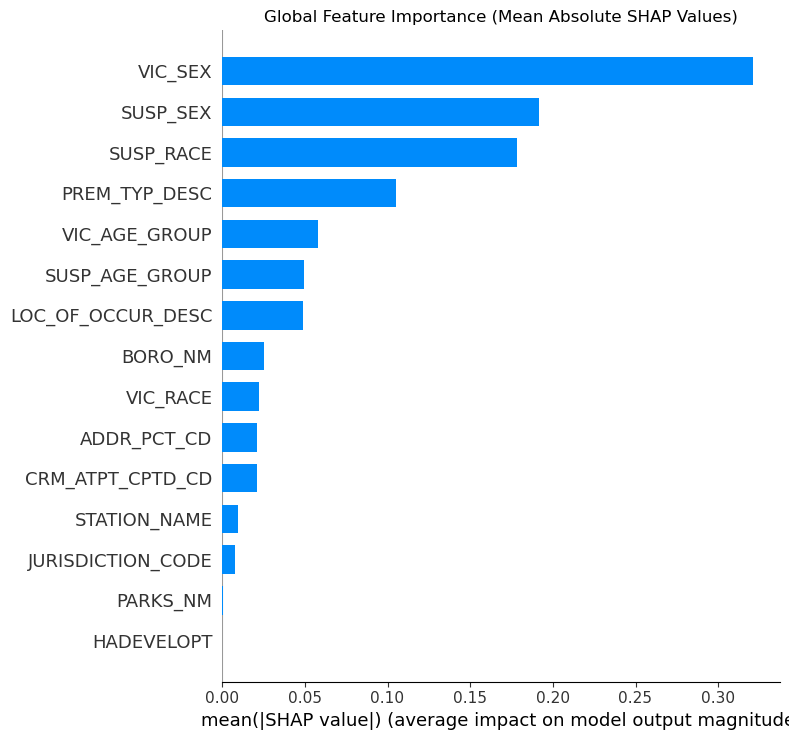

In [9]:
# 7. Create SHAP summary plots using mean absolute values
# Bar plot showing global feature importance
print("Creating SHAP bar plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(mean_shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance (Mean Absolute SHAP Values)")
plt.tight_layout()
plt.show()

Creating SHAP beeswarm plot...


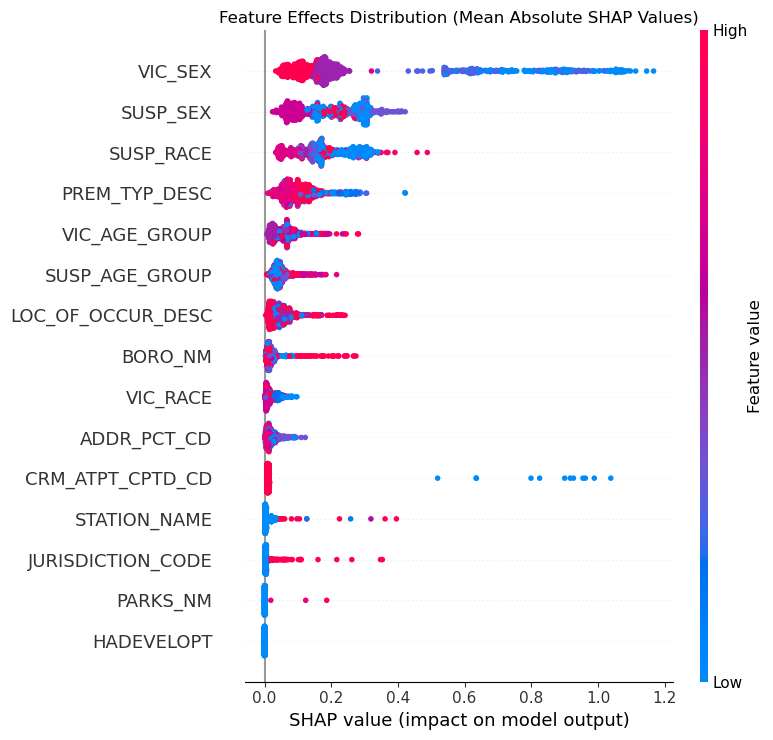

In [10]:
# 8. Beeswarm plot showing feature effects
print("Creating SHAP beeswarm plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(mean_shap_values, X_sample, show=False)
plt.title("Feature Effects Distribution (Mean Absolute SHAP Values)")
plt.tight_layout()
plt.show()


LOCAL EXPLANATIONS FOR INDIVIDUAL INSTANCES
Selected instances at indices: [2226836 1457539]

--- LOCAL EXPLANATION FOR INSTANCE 1 (Index: 2226836) ---
Actual Crime Type: FELONY
Predicted Crime Type: MISDEMEANOR
Prediction Confidence: 0.7379

Top 3 Predicted Classes:
  1. MISDEMEANOR: 0.7379
  2. FELONY: 0.2566
  3. VIOLATION: 0.0055

Feature Values for Instance 1:
  ADDR_PCT_CD: 48.0 (encoded: 47)
  CRM_ATPT_CPTD_CD: COMPLETED (encoded: 2)
  BORO_NM: BRONX (encoded: 1)
  LOC_OF_OCCUR_DESC: FRONT OF (encoded: 1)
  PREM_TYP_DESC: RESTAURANT/DINER (encoded: 72)
  JURISDICTION_CODE: 0
  PARKS_NM: (null) (encoded: 1)
  HADEVELOPT: (null) (encoded: 0)
  SUSP_AGE_GROUP: (null) (encoded: 0)
  SUSP_RACE: (null) (encoded: 0)
  SUSP_SEX: (null) (encoded: 0)
  STATION_NAME: (null) (encoded: 0)
  VIC_AGE_GROUP: (null) (encoded: 0)
  VIC_RACE: UNKNOWN (encoded: 6)
  VIC_SEX: D (encoded: 1)

Creating waterfall plot for predicted class: MISDEMEANOR


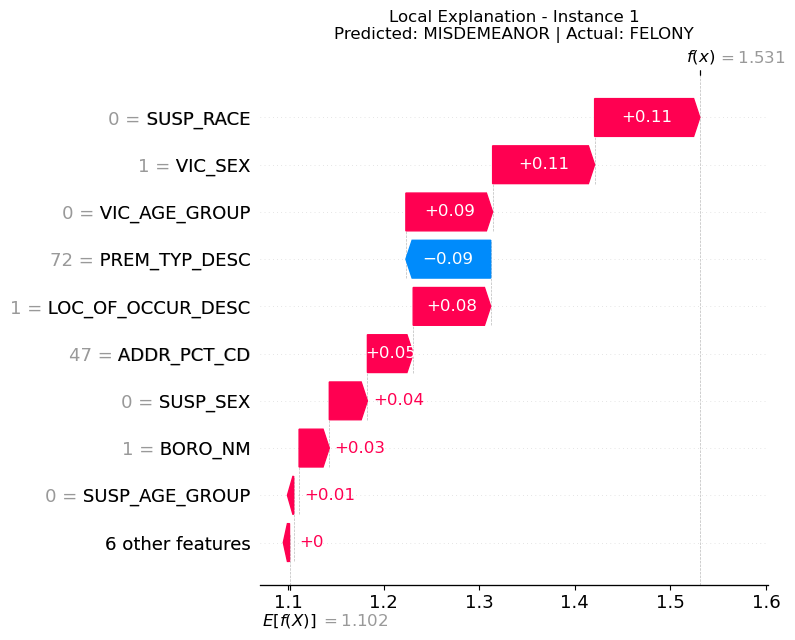

Creating force plot for instance 1...


<Figure size 1200x400 with 0 Axes>

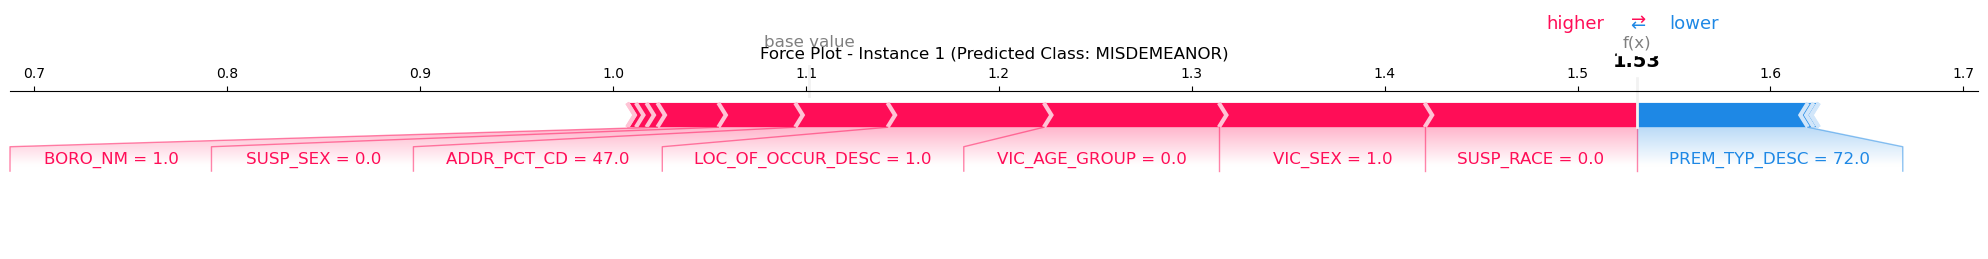


Top 5 Most Important Features for Instance 1:
  1. SUSP_RACE = '(null)' -> increases prediction by 0.1100
  2. VIC_SEX = 'D' -> increases prediction by 0.1067
  3. VIC_AGE_GROUP = '(null)' -> increases prediction by 0.0907
  4. PREM_TYP_DESC = 'RESTAURANT/DINER' -> decreases prediction by 0.0887
  5. LOC_OF_OCCUR_DESC = 'FRONT OF' -> increases prediction by 0.0811

--- LOCAL EXPLANATION FOR INSTANCE 2 (Index: 1457539) ---
Actual Crime Type: MISDEMEANOR
Predicted Crime Type: MISDEMEANOR
Prediction Confidence: 0.7794

Top 3 Predicted Classes:
  1. MISDEMEANOR: 0.7794
  2. FELONY: 0.2155
  3. VIOLATION: 0.0050

Feature Values for Instance 2:
  ADDR_PCT_CD: 9.0 (encoded: 75)
  CRM_ATPT_CPTD_CD: COMPLETED (encoded: 2)
  BORO_NM: MANHATTAN (encoded: 3)
  LOC_OF_OCCUR_DESC: INSIDE (encoded: 2)
  PREM_TYP_DESC: GROCERY/BODEGA (encoded: 38)
  JURISDICTION_CODE: 0
  PARKS_NM: (null) (encoded: 1)
  HADEVELOPT: (null) (encoded: 0)
  SUSP_AGE_GROUP: (null) (encoded: 0)
  SUSP_RACE: (null) (encoded

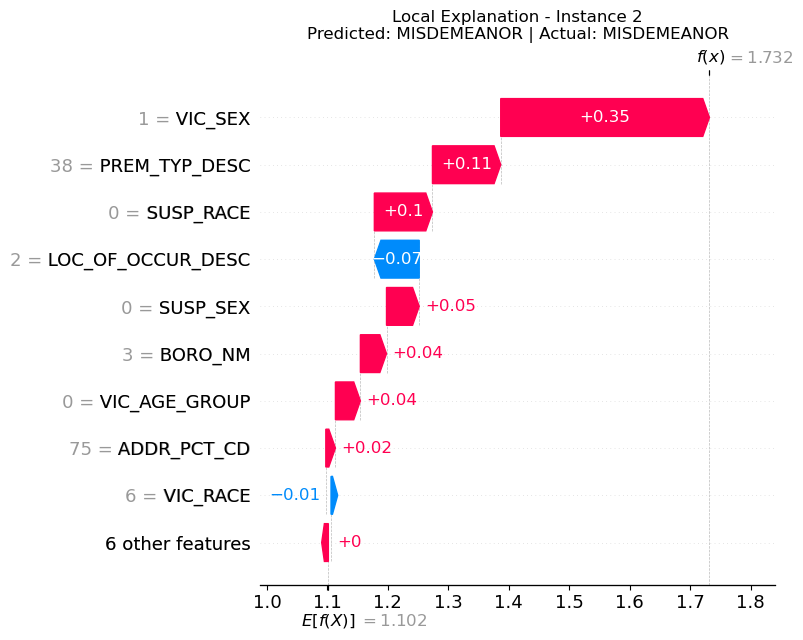

Creating force plot for instance 2...


<Figure size 1200x400 with 0 Axes>

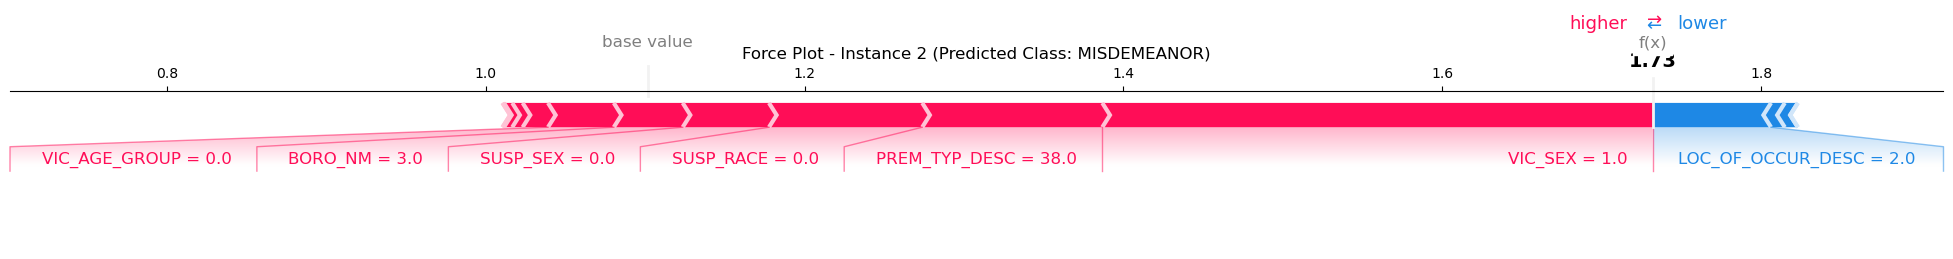


Top 5 Most Important Features for Instance 2:
  1. VIC_SEX = 'D' -> increases prediction by 0.3452
  2. PREM_TYP_DESC = 'GROCERY/BODEGA' -> increases prediction by 0.1129
  3. SUSP_RACE = '(null)' -> increases prediction by 0.0961
  4. LOC_OF_OCCUR_DESC = 'INSIDE' -> decreases prediction by 0.0742
  5. SUSP_SEX = '(null)' -> increases prediction by 0.0541

LOCAL EXPLANATIONS COMPLETE


In [20]:
# 9. LOCAL EXPLANATIONS FOR 2 RANDOM INSTANCES
print("\n" + "="*50)
print("LOCAL EXPLANATIONS FOR INDIVIDUAL INSTANCES")
print("="*50)

# Select 2 random instances from the test set
np.random.seed(123)  # For reproducibility
random_indices = np.random.choice(X_test.index, size=2, replace=False)

print(f"Selected instances at indices: {random_indices}")

for i, instance_idx in enumerate(random_indices):
    print(f"\n--- LOCAL EXPLANATION FOR INSTANCE {i+1} (Index: {instance_idx}) ---")
    
    # Get the single instance
    single_instance = X_test.loc[[instance_idx]]
    actual_crime = y_test.loc[instance_idx]
    
    # Get model prediction for this instance
    predicted_crime = xgb_clf.predict(single_instance)[0]
    prediction_proba = xgb_clf.predict_proba(single_instance)[0]
    
    # Get actual and predicted crime names
    actual_crime_name = label_encoders['LAW_CAT_CD'].inverse_transform([actual_crime])[0]
    predicted_crime_name = label_encoders['LAW_CAT_CD'].inverse_transform([predicted_crime])[0]
    
    # Get top 3 predicted classes with probabilities
    top_3_indices = np.argsort(prediction_proba)[-3:][::-1]
    top_3_probs = prediction_proba[top_3_indices]
    top_3_crimes = label_encoders['LAW_CAT_CD'].inverse_transform(top_3_indices)
    
    print(f"Actual Crime Type: {actual_crime_name}")
    print(f"Predicted Crime Type: {predicted_crime_name}")
    print(f"Prediction Confidence: {prediction_proba[predicted_crime]:.4f}")
    print("\nTop 3 Predicted Classes:")
    for j, (crime, prob) in enumerate(zip(top_3_crimes, top_3_probs)):
        print(f"  {j+1}. {crime}: {prob:.4f}")
    
    # Compute SHAP values for this single instance
    single_shap_values = explainer.shap_values(single_instance)
    
    # For multiclass, we need to look at SHAP values for the predicted class
    predicted_class_shap = single_shap_values[:, :, predicted_crime]
    
    # Display feature values for context
    print(f"\nFeature Values for Instance {i+1}:")
    feature_names = X_test.columns.tolist()
    for feat_name, feat_val in zip(feature_names, single_instance.iloc[0]):
        # Try to get original categorical value if possible
        if feat_name in label_encoders:
            try:
                original_val = label_encoders[feat_name].inverse_transform([int(feat_val)])[0]
                print(f"  {feat_name}: {original_val} (encoded: {feat_val})")
            except:
                print(f"  {feat_name}: {feat_val}")
        else:
            print(f"  {feat_name}: {feat_val}")
    
    # Create waterfall plot for the predicted class
    print(f"\nCreating waterfall plot for predicted class: {predicted_crime_name}")
    plt.figure(figsize=(12, 8))
    
    # Create SHAP Explanation object for waterfall plot
    shap_explanation = shap.Explanation(
        values=predicted_class_shap[0],
        base_values=explainer.expected_value[predicted_crime],
        data=single_instance.iloc[0].values,
        feature_names=feature_names
    )
    
    shap.plots.waterfall(shap_explanation, show=False)
    plt.title(f"Local Explanation - Instance {i+1}\nPredicted: {predicted_crime_name} | Actual: {actual_crime_name}")
    plt.tight_layout()
    plt.show()
    
    # Create force plot (alternative visualization)
    print(f"Creating force plot for instance {i+1}...")
    plt.figure(figsize=(12, 4))
    
    # Force plot for the predicted class
    shap.plots.force(
        explainer.expected_value[predicted_crime], 
        predicted_class_shap[0], 
        single_instance.iloc[0],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"Force Plot - Instance {i+1} (Predicted Class: {predicted_crime_name})")
    plt.tight_layout()
    plt.show()
    
    # Show top contributing features
    feature_contributions = list(zip(feature_names, predicted_class_shap[0]))
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\nTop 5 Most Important Features for Instance {i+1}:")
    for j, (feat_name, contribution) in enumerate(feature_contributions[:5]):
        direction = "increases" if contribution > 0 else "decreases"
        if feat_name in label_encoders:
            try:
                original_val = label_encoders[feat_name].inverse_transform([int(single_instance.iloc[0][feat_name])])[0]
                print(f"  {j+1}. {feat_name} = '{original_val}' -> {direction} prediction by {abs(contribution):.4f}")
            except:
                print(f"  {j+1}. {feat_name} = {single_instance.iloc[0][feat_name]} -> {direction} prediction by {abs(contribution):.4f}")
        else:
            print(f"  {j+1}. {feat_name} = {single_instance.iloc[0][feat_name]} -> {direction} prediction by {abs(contribution):.4f}")

print(f"\n{'='*50}")
print("LOCAL EXPLANATIONS COMPLETE")
print(f"{'='*50}")